# Lab 1d: K-Means Clustering Analysis of a Heart Failure Clinical Dataset
In this lab, we will cluster a dataset describing the clinical risk factors linked with death from heart disease using [the K-means clustering algorithm](https://en.wikipedia.org/wiki/K-means_clustering).

In this dataset, several risk factors (features) are measured per patient (some of these features are continuous, some are categorical), along with the binary clinical outcome (target variable) `{death | not death}.` 

> __Learning Objectives__
> 
> By the end of this lab, you will be able to:
>
> * __Apply K-means clustering to clinical data:__ Implement K-means clustering on a heart disease dataset with mixed continuous and categorical features, including data preprocessing through binary recoding and z-score normalization.
> * __Validate clustering convergence through energy minimization:__ Compute and visualize the configuration energy of K-means clustering to verify that the algorithm converges to a stable state through iterative assignment and centroid updates.
> * __Interpret cluster composition and clinical patterns:__ Analyze cluster membership and centroid values to identify patterns in patient risk factors and assess whether feature similarity corresponds to clinical outcomes.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Data
Next, let's load up the dataset that we will explore. The data for this lab was taken from this `2020` publication:
* [Davide Chicco, Giuseppe Jurman: "Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone." BMC Medical Informatics and Decision Making 20, 16 (2020). https://doi.org/10.1186/s12911-020-1023-5](https://pubmed.ncbi.nlm.nih.gov/32013925/)

In this paper, the authors analyzed a dataset of 299 heart failure patients collected in 2015. The patients comprised 105 women and 194 men, aged between 40 and 95 years old. The dataset contains 13 features (a mixture of continuous and categorical data), which report clinical, body, and lifestyle information:
* Some features are binary: anemia, high blood pressure, diabetes, sex, and smoking status.
* The remaining features were continuous biochemical measurements, such as the level of the Creatinine phosphokinase (CPK) enzyme in the blood, the number of platelets, etc.
* The class (target) variable is encoded as a binary (boolean) death event: `1` if the patient died during the follow-up period, `0` if the patient did not die during the follow-up period.

We'll load this dataset as a [DataFrame instance](https://dataframes.juliadata.org/stable/) and store it in the `originaldataset::DataFrame` variable:

In [2]:
originaldataset = MyHeartDiseaseClinicalDataset(); # load the heart disease dataset

#### Data scaling
We know from lecture that [the K-means approach](https://en.wikipedia.org/wiki/K-means_clustering) works on [an instance of a `Matrix`](https://docs.julialang.org/en/v1/base/arrays/#Base.Matrix-Tuple{UndefInitializer,%20Any,%20Any}) and not [a `DataFrame` instance](https://dataframes.juliadata.org/stable/). Thus, we need to convert the data to [a `Matrix`](https://docs.julialang.org/en/v1/base/arrays/#Base.Matrix-Tuple{UndefInitializer,%20Any,%20Any}). In addition, there are several ways we can pretreat the data to make the clustering easier.
* Convert `0,1` data to `-1,1`. This is a preference (not technically required), but it makes (binary) classification problems easier, so let's convert all categorical `0,1` data to `-1,1`. In this rescaled data, `0` will be replaced by `-1`. Thus, _false_ will be mapped to `-1`, and _true_ will remain `1`.
* Next, let's [z-score center](https://en.wikipedia.org/wiki/Feature_scaling) the continous feature data. In [z-score feature scaling](https://en.wikipedia.org/wiki/Feature_scaling), we subtract off the mean of each feature and then divide by the standard deviation, i.e., $x^{\prime} = (x - \mu)/\sigma$ where $x$ is the unscaled data, and $x^{\prime}$ is the scaled data. Under this scaling regime, $x^{\prime}\leq{0}$ will be values that are less than or equal to the mean value $\mu$, while $x^{\prime}>0$ indicate values that are greater than the mean. The range of data is measured in quanta of the standard deviation $\sigma$.
* Finally, we can include (exclude) specific data from the clustering problem. For example, let's initially exclude the `death_event` label data and explore the hypothesis underlying [K-means](https://en.wikipedia.org/wiki/K-means_clustering) that feature vectors that are close together will be similar, i.e., have the same `death_event` label value.

In [3]:
(D, dataset) = let

    # convert 0,1 into -1,1
    treated_dataset = copy(originaldataset);
    transform!(treated_dataset, :anaemia => ByRow(x -> (x==0 ? -1 : 1)) => :anaemia); # maps anaemia to -1,1
    transform!(treated_dataset, :diabetes => ByRow(x -> (x==0 ? -1 : 1)) => :diabetes); # maps diabetes to -1,1
    transform!(treated_dataset, :high_blood_pressure => ByRow(x -> (x==0 ? -1 : 1)) => :high_blood_pressure); # maps high_blood_pressure to -1,1
    transform!(treated_dataset, :sex => ByRow(x -> (x==0 ? -1 : 1)) => :sex); # maps sex to -1,1
    transform!(treated_dataset, :smoking => ByRow(x -> (x==0 ? -1 : 1)) => :smoking); # maps smoking to -1,1
    transform!(treated_dataset, :death_event => ByRow(x -> (x==0 ? -1 : 1)) => :death_event); # maps death_event to -1,1
    
    D = treated_dataset[:,1:end] |> Matrix; # build a data matrix from the DataFrame
    (number_of_examples, number_of_features) = size(D);

    # Which cols do we want to rescale?
    index_to_z_scale = [
        1 ; # 1 age
        3 ; # 2 creatinine_phosphokinase
        5 ; # 3 ejection_fraction
        7 ; # 4 platelets
        8 ; # 5 serum_creatinine
        9 ; # 6 serum_sodium
        12 ; # 7 time
    ];

    D̂ = copy(D);
    for i ∈ eachindex(index_to_z_scale)
        j = index_to_z_scale[i];
        μ = mean(D[:,j]); # compute the mean
        σ = std(D[:,j]); # compute std

        # rescale -
        for k ∈ 1:number_of_examples
            D̂[k,j] = (D[k,j] - μ)/σ;
        end
    end

    # remove categorical cols -
    # D̂₂ = D̂[:,index_to_z_scale]; # z-scaled data, no label, no categorical
    D̂₂ = D̂[:,1:end-1]; # z-scaled data, no label, with unscaled categorical
    #D̂₂ = D̂[:,1:end-1]; # raw (unscaled) data, no label
    
    D̂₂, treated_dataset
end;

What's in the `D::Array{Float64,2}` variable?

In [4]:
D

299×12 Matrix{Float64}:
  1.19095    -1.0   0.000165451  -1.0  …  -1.50152     1.0  -1.0  -1.62678
 -0.490457   -1.0   7.50206      -1.0     -0.141739    1.0  -1.0  -1.60101
  0.350246   -1.0  -0.449186     -1.0     -1.72815     1.0   1.0  -1.58812
 -0.910808    1.0  -0.485257     -1.0      0.0848915   1.0  -1.0  -1.58812
  0.350246    1.0  -0.434757      1.0     -4.67434    -1.0  -1.0  -1.57524
  2.452       1.0  -0.551217     -1.0  …  -1.04826     1.0   1.0  -1.57524
  1.19095     1.0  -0.346124     -1.0      0.0848915   1.0  -1.0  -1.54947
 -0.0701056   1.0  -0.275011      1.0     -1.27489     1.0   1.0  -1.54947
  0.350246   -1.0  -0.437849     -1.0      0.311522   -1.0  -1.0  -1.54947
  1.6113      1.0  -0.47289      -1.0     -0.821629    1.0   1.0  -1.54947
  ⋮                                    ⋱                     ⋮    
 -1.33116    -1.0   0.034176      1.0  …   0.991412   -1.0  -1.0   1.63294
 -0.0701056  -1.0  -0.269858     -1.0      0.538152    1.0  -1.0   1.64582
 -0.74266

Finally, let's set some constants that we'll need in the examples below. See the comment next to the constant for a description of what it is, it's permissible values, etc.

In [5]:
n = nrow(originaldataset); # how many example data points do we have?
m = size(D,2); # number of features (number of cols)
maxiter = 10000; # maximum iterations
K = 5; # number of clusters. What number should we pick?
ϵ = 1e-6; # tolerance for termination. We can set this to whatever we want

In [6]:
"""
    configurationenergy(data::Array{<:Number,2}, assignments::Array{Int64,1}, centroids::Dict{Int64, Vector{Float64}}; d = Euclidean())::Float64

The function computes the energy of the configuration of the data points given the assignments and the centroids.

### Arguments
- `data::Array{<:Number,2}`: A matrix of size `(N, D)` where `N` is the number of data points and `D` is the dimension of the data points.
- `assignments::Array{Int64,1}`: A vector of size `N` where each element is the cluster assignment of the corresponding data point.
- `centroids::Dict{Int64, Vector{Float64}}`: A dictionary where the keys are the cluster indices and the values are the centroids of the clusters.
- `d::MyAbstractDistanceMetric = Euclidean()`: A distance metric. Default is `Euclidean()`.

### Returns
- `Float64`: The energy of the configuration.
"""
function configurationenergy(data::Array{<:Number,2}, assignments::Array{Int64,1}, centroids::Dict{Int64, Vector{Float64}}; 
    d = Euclidean())::Float64
    
    # initialize -
    K = length(centroids); # number of clusters -
    energy = 0.0;
    
    # compute the energy -
    for k ∈ 1:K
        index_cluter_k = findall(x-> x == k, assignments); # index of the data vectors assigned to cluster k
        for i ∈ eachindex(index_cluter_k)
            j = index_cluter_k[i];
            energy += d(data[j,:], centroids[k])^2;
        end
    end
    
    # return the energy -
    return energy;
end

configurationenergy

___

## Task 1: Build a K-means model and cluster the data
We've developed an [initial K-means implementation](src/Cluster.jl) based on [our pseudo-code](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-1/L1c/docs/L1c-5820-S2025.pdf). Let's explore how this implementation performs on our sample dataset. There is [already a good clustering package `Clustering.jl` that is available](https://github.com/JuliaStats/Clustering.jl) that exports [a `K-means` function](https://juliastats.org/Clustering.jl/stable/kmeans.html). However, in this demo, we'll use our implementation.
> __Model__ 
> 
> Let's build [a `MyNaiveKMeansClusteringAlgorithm` instance](src/Types.jl), which holds information about the clustering, i.e., the number of clusters `K::Int,` information about the dataset such as the number of features `m::Int,` and the number of points `n::Int,` and stopping criteria information such as the maximum number of iterations `maxiter::Int` and tolerance `ϵ::Float64`. We'll store this model in the `model::MyNaiveKMeansClusteringAlgorithm` variable.

This is an example of [a factory type pattern](https://en.wikipedia.org/wiki/Factory_method_pattern), which uses [a `build(...)` method](src/Factory.jl) to construct and configure a complex object, i.e., set values for the properties on the model that must be computed. The [`build(...)` method](src/Factory.jl) takes the type of thing we want to build as the first argument, and the data required to construct the object (encoded [in a `NamedTupe` type](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple)) as the second argument.

In [7]:
model = build(MyNaiveKMeansClusteringAlgorithm, (
        maxiter = maxiter,
        dimension = m,
        number_of_points = n,
        K = K,
        ϵ = ϵ,
        scale_factor = 1.0, # scale of the data
));

### Initial clustering values
The `model::MyNaiveKMeansClusteringAlgorithm` contains the data that we passed in, as well as two derived fields that we computed in [the `build(...)` method](src/Factory.jl), the centroids and initial assignments: 
* The `centroids::Dict{Int64, Vector{Float64}}` dictionary holds the centroid values $\mu_1, \dots, \mu_K$ for each cluster. The dictionary's keys are the cluster index, while the values are the `m`-dimensional centroids (means) of the data points in that cluster. We initialize the centroids randomly.
* The `assignments::Vector{Int64}` field is an `n`-dimensional vector holding the clustered index that each data point is assigned to. We initialize the assignments randomly.

What is in the `centroids` and `assignments` fields of your model?

In [8]:
model.centroids

Dict{Int64, Vector{Float64}} with 5 entries:
  5 => [0.0802351, 0.166753, 0.848295, 0.344133, 0.375298, 0.527701, 0.631961, …
  4 => [0.977495, 0.413704, 0.229229, 0.502064, 0.807079, 0.0587564, 0.271953, …
  2 => [0.0177797, 0.115794, 0.600763, 0.172338, 0.489116, 0.334725, 0.11819, 0…
  3 => [0.538197, 0.266027, 0.150942, 0.412409, 0.521601, 0.202546, 0.0365833, …
  1 => [0.862986, 0.214567, 0.345691, 0.617743, 0.417337, 0.823747, 0.403868, 0…

### Clustering
We'll call [the `cluster(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/clustering/#VLDataScienceMachineLearningPackage.cluster) to refine our initial random cluster assignments and centroid values. The [`cluster(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/clustering/#VLDataScienceMachineLearningPackage.cluster) takes a few arguments (and returns the clustering results):

* __Data__: `D::Array{<:Number, 2}`: The first argument is the data matrix `D::Array{<:Number,2}` which we want to cluster. The data matrix has the feature vectors $\mathbf{x}\in\mathbb{R}^{m}$ as columns. Its values can be any subtype [of Number](https://docs.julialang.org/en/v1/base/numbers/#Core.Number). 
* __Model__: `model::<: MyAbstractUnsupervisedClusteringAlgorithm`: The second argument is the cluster model instance, i.e.,  the `model::MyNaiveKMeansClusteringAlgorithm` instance that we built above. However, the model can be any subtype of ` MyAbstractUnsupervisedClusteringAlgorithm.`
    * __Why an abstract generic type?__ Suppose we have different K-means implementations or different clustering logic altogether. In that case, we can take advantage of Julia's multiple dispatch functionality by passing in a different clustering model. This provides a single method for a user to call, which calls a different implementation.
* __Verbose (optional)__: `verbose::Bool`: The `verbose::Bool` argument tells our implementation whether to save data from each algorithm iteration. The default value is `false`. However, if the value is set to `true,` a save file holding the assignments, centroids, and loop index is written at each iteration. The `tmpdir::String` argument specifies the directory where the save files are written. By default, we use the current directory `.`.
* __Measure (optional)__:`d::Any`. The optional distance argument is the $d(p,q)$ function and can be used to change how the similarity between feature vectors $\mathbf{x}\in\mathcal{D}$ is calculated. We can use [any metrics exported by the `Distances.jl` package](https://github.com/JuliaStats/Distances.jl); by default, we [use the Euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance). 

The [`cluster(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/clustering/#VLDataScienceMachineLearningPackage.cluster) returns cluster centroids, the assignments, and the number of iterations that it took to reach the final assignment in the `results::NamedTuple.`

In [9]:
result = cluster(D, model, verbose = true, tmpdir = _PATH_TO_TMP); # cluster the data, save each stage to disk in the tmp folder (verbose = true). This tmp folder must exists

The `result` tuple has the fields `{assignments|centroids|loopcount).` The `assignments` field is an array of integers that tells us which cluster each data point belongs to. The `centroids` field is a dictionary holding the centroids of the clusters. The `loopcount` field is an integer that tells us how many iterations the algorithm took to converge.

In [10]:
result.assignments

299-element Vector{Int64}:
 1
 5
 3
 2
 2
 1
 1
 3
 4
 5
 ⋮
 4
 3
 3
 3
 3
 4
 4
 3
 3

In [11]:
result.centroids

Dict{Int64, Vector{Float64}} with 5 entries:
  5 => [0.0139647, -0.333333, 3.13394, -0.333333, 0.183052, -0.5, 0.0242148, 2.…
  4 => [-0.211459, -0.205882, -0.0575645, 0.0, 0.554587, -0.617647, 0.342846, -…
  2 => [-0.450948, -0.114754, -0.105093, 0.344262, -0.640094, -0.606557, -0.189…
  3 => [-0.0908637, -0.407407, -0.149427, -0.432099, -0.114511, -0.777778, -0.0…
  1 => [0.637395, 0.220779, -0.197125, -0.402597, 0.109255, 0.766234, -0.057068…

Finally, how balanced are the clusters? Let's compute the fraction of our patient population in each cluster, and display this information in a table [using the `pretty_table(...)` function exported by the `PrettyTables.jl` package](https://github.com/ronisbr/PrettyTables.jl)

In [12]:
let

    df = DataFrame(); # container for the fraction data
    
    for k ∈ 1:K # iterate over the number of clusters
        Nᵢ = findall(x-> x == k, result.assignments) |> length;
        row_df = (
            cluster = k,
            fraction = (Nᵢ/n)
        );
        push!(df, row_df)
    end

    # make a pretty table
    pretty_table(
        df;
        backend = :text,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 --------- -----------
  cluster    fraction 
    Int64     Float64 
 --------- -----------
        1    0.257525
        2    0.204013
        3    0.270903
        4    0.227425
        5   0.0401338
 --------- -----------


### Check: Does the Energy decrease?
The problem of [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) can be formulated as an optimization problem, 
where the objective is to minimize the sum of squared distances between each data point and its assigned cluster centroid. If we think about this objective in terms of a pseudo-energy $E(c_{1},\dots,c_{K})$, then we are looking for the cluster assignments that minimize the energy:
$$
\begin{equation}
\min_{c_{1},\dots,c_{K}} E\left(c_{1},\dots,c_{K}\right)= \sum_{j=1}^{K}\sum_{\mathbf{x}\in c_{j}}d(\mathbf{x},\mu_{j})^{2}\quad\text{where}\,\mu_{j} = |c_{j}|^{-1}\cdot\sum_{\mathbf{x}\in{c_{j}}}\mathbf{x}
\end{equation}
$$
where $d(\mathbf{x},\mu_{j})$ denotes the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between two vectors (in this case, a feature vector and the cluster centroid), 
and $|c_{\star}|$ denotes the number of elements in cluster $\star$. The K-means algorithm aims to find the optimal cluster assignments $\mathcal{C}$ and cluster centroids $\mu$ that minimize this objective function.

We need to compute the pseudo-energy $E(c_{1},\dots,c_{K})$ from the iteration data files. What's in these files?

In [13]:
tmp = load(joinpath(_PATH_TO_TMP, "data-1.jld2"))

Dict{String, Any} with 3 entries:
  "centroids"   => Dict(5=>[0.0802351, 0.166753, 0.848295, 0.344133, 0.375298, …
  "loopcount"   => 1
  "assignments" => [2, 2, 5, 1, 5, 1, 4, 1, 5, 4  …  5, 5, 4, 2, 5, 5, 4, 1, 3,…

Given the cluster results that we saved at each iteration (when `verbose = true`), we can compute the values for the pseudo-energy $E(c_{1},\dots,c_{K})$ as a function iteration. Save that data in the `energy_array::Array{Float64,2}` array.

> __Plan:__ To compute pseudo-energy $E(c_{1},\dots,c_{K})$, we call [the `configurationenergy(...)` function](src/Cluster.jl). This function takes the dataset $\mathcal{D}$, the cluster assignment array, and the centroid array and returns the energy for that configuration. Because we don't care about the actual value of energy $E(c_{1},\dots,c_{K})$, we'll scale this to be in the range `[0,1]`.

In [14]:
energy_array = let

    number_of_iterations = result.loopcount; # how many iterations did we take to converge?
    energy_array = Array{Float64,1}(undef, number_of_iterations);
    
    # compute the (unscaled) energy for each configuration
    for i ∈ 1:number_of_iterations
        tmp = load(joinpath(_PATH_TO_TMP, "data-$(i).jld2")); # returns a dictionary
        a = tmp["assignments"]; # get the assignment vector for this iteration
        μ = tmp["centroids"]; # get the cluster centroids for this iteration
        energy_array[i] = configurationenergy(D, a, μ); # call the energy function with ith clustering resulys
    end

    # 0,1 scale the energy
    L = minimum(energy_array); # low value
    H = maximum(energy_array); # high value
    scaled_energy_array = Array{Float64,2}(undef, number_of_iterations,2);
    for i ∈ 1:number_of_iterations
        scaled_energy_array[i,1] = i; # save the iteration count in col 1
        scaled_energy_array[i,2] = (energy_array[i] - L)/(H - L); # save 0,1 scaled energy in col 2
    end

    # return 
    scaled_energy_array
end;

#### Visualize
`Unhide` the code block below to see how we plotted the scaled energy as a function of the number of iterations of [our K-means implementation](src/Cluster.jl). If the clustering worked properly, we should see the energy (scaled) decrease and flatten out (converge) as the number of iterations increases.

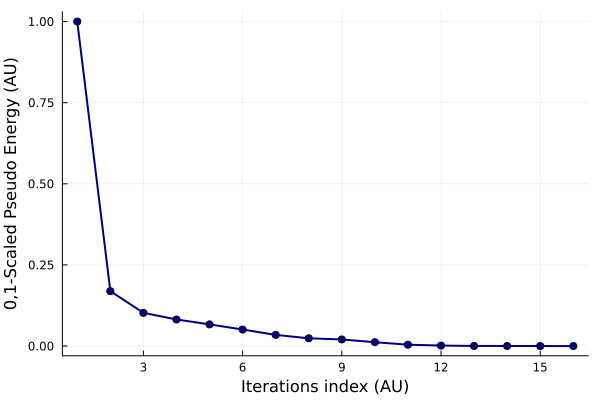

In [15]:
let
    plot(energy_array[:,1],energy_array[:,2], lw=2, c=:navy, label="") 
    scatter!(energy_array[:,1], energy_array[:,2], c=:navy, label="")
    xlabel!("Iterations index (AU)", fontsize=18)
    ylabel!("0,1-Scaled Pseudo Energy (AU)", fontsize=18)
end

## Task 2: Interpretation of the data in the clusters
We've run the clustering algorithm on the clinical dataset. Now, let's figure out what is in each cluster. In particular, specify which cluster we want to analyze in the `my_cluster_index::Int64` variable, where `my_cluster_index` $\in\left\{1,2,\dots,K\right\}$.

In [16]:
my_cluster_index = 3; # i ∈ {1,2,...,K}

Next, let's make a table [using the `pretty_table(...)` function exported by the `PrettyTables.jl` package](https://github.com/ronisbr/PrettyTables.jl) which displays the raw data associated with `my_cluster_index::Int64`. This table will display the raw (scaled) data from `D::Array{Float64,2}`. 

In [20]:
let

    # names - 
    names_dictionary = Dict{String,Int}();
    loopcounter = 1;
    for name ∈ names(dataset)
        names_dictionary[name] = loopcounter;
        loopcounter += 1;
    end

    df = DataFrame(); 
    assignment = result.assignments;
    index_array = findall(a -> a == my_cluster_index, assignment);

    for i ∈ eachindex(index_array)
        a = index_array[i]; # what is the assignment
        row_df = (
            c = my_cluster_index,
            id = a, # proxy for patient id?
            age = D[a,names_dictionary["age"]],
            gender = D[a,names_dictionary["sex"]],
            high_blood_pressure = D[a,names_dictionary["high_blood_pressure"]],
            serum_sodium = D[a,names_dictionary["serum_sodium"]],
            serum_creatinine = D[a, names_dictionary["serum_creatinine"]],
            ejection_fraction = D[a, names_dictionary["ejection_fraction"]],
            smoking = D[a,names_dictionary["smoking"]],
            death = dataset[a, :death_event] # this was NOT included in the cluster dataset D
        );
        push!(df, row_df);
    end
    
    pretty_table(
        df;
        backend = :text,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 ------- ------- ------------ --------- --------------------- -------------- ---
      c      id          age    gender   high_blood_pressure   serum_sodium    ⋯
  Int64   Int64      Float64   Float64               Float64        Float64    ⋯
 ------- ------- ------------ --------- --------------------- -------------- ---
      3       3     0.350246       1.0                  -1.0       -1.72815    ⋯
      3       8   -0.0701056       1.0                  -1.0       -1.27489    ⋯
      3      26       1.6113       1.0                  -1.0         1.6713    ⋯
      3      30      1.77944       1.0                  -1.0       -1.04826    ⋯
      3      46    -0.910808       1.0                  -1.0      -0.368369    ⋯
      3      57     0.770597       1.0                  -1.0       0.311522    ⋯
      3      58   -0.0701056       1.0                  -1.0       0.311522    ⋯
      3      59    -0.994879       1.0                   1.0      -0.141739    ⋯
      3      63    -0.490457

We can see the averages, i.e., the centroids of each feature in the `my_cluster_index::Int` by looking at the centroids dictionary. This will give us a representation of the data in this cluster.

In [22]:
let

    # names - 
    names_dictionary = Dict{String,Int}();
    loopcounter = 1;
    for name ∈ names(dataset)
        names_dictionary[name] = loopcounter;
        loopcounter += 1;
    end

    # for this cluster configuration, what is the death centroid?
    tmp = 0.0;
    idx_cluster = findall(x-> x == my_cluster_index, result.assignments);
    N = length(idx_cluster);
    for i ∈ idx_cluster
        tmp += dataset[i,:death_event];
    end
    death_centroid = (1/N)*tmp;
    
    μ = result.centroids[my_cluster_index]
    df = DataFrame();
    row_df = (
        c = my_cluster_index,
        age = μ[names_dictionary["age"]],
        gender = μ[names_dictionary["sex"]],
        high_blood_pressure = μ[names_dictionary["high_blood_pressure"]],
        serum_sodium = μ[names_dictionary["serum_sodium"]],
        serum_creatinine = μ[names_dictionary["serum_creatinine"]],
        ejection_fraction = μ[names_dictionary["ejection_fraction"]],
        smoking = μ[names_dictionary["smoking"]],
        death = death_centroid,
    );
    push!(df, row_df);
    
    pretty_table(
        df;
        backend = :text,
        fit_table_in_display_horizontally = false,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 ------- ------------ --------- --------------------- -------------- ------------------ ------------------- ---------- -----------
      c          age    gender   high_blood_pressure   serum_sodium   serum_creatinine   ejection_fraction    smoking       death 
  Int64      Float64   Float64               Float64        Float64            Float64             Float64    Float64     Float64 
 ------- ------------ --------- --------------------- -------------- ------------------ ------------------- ---------- -----------
      3   -0.0908637       1.0             -0.777778       0.199606          -0.232403           -0.114511   0.654321   -0.580247
 ------- ------------ --------- --------------------- -------------- ------------------ ------------------- ---------- -----------


___

## Summary
This lab demonstrated K-means clustering on a heart disease clinical dataset, validating convergence through energy minimization and analyzing cluster composition to explore patterns in patient risk factors.

> __Key Takeaways:__
> 
> * **Feature preprocessing enables effective clustering:** Z-score normalization of continuous variables and binary recoding of categorical features to {-1,1} standardizes the data space for distance-based clustering algorithms.
> * **Energy minimization validates convergence:** The sum of squared distances between data points and their assigned cluster centroids decreases monotonically during K-means iteration, confirming the algorithm converges to a stable cluster assignment.
> * **Cluster analysis reveals clinical patterns:** Post-clustering analysis of centroid values and cluster membership distributions identifies patient subgroups with similar risk factor profiles, enabling investigation of feature-outcome relationships.


K-means clustering provides a data-driven approach to stratify patients based on clinical features, supporting hypothesis generation about heart disease risk factors.
___